2025-01-22 16:40:14,135 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2025-01-22 16:40:14,149 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2025-01-22 16:40:14,164 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.9e+01/s
2025-01-22 16:40:14,177 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2025-01-22 16:40:14,191 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.6e+01/s
2025-01-22 16:40:14,203 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2025-01-22 16:40:14,215 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2025-01-22 16:40:14,233 subsystems 0/1 INFO :: Building subproblem matrices 

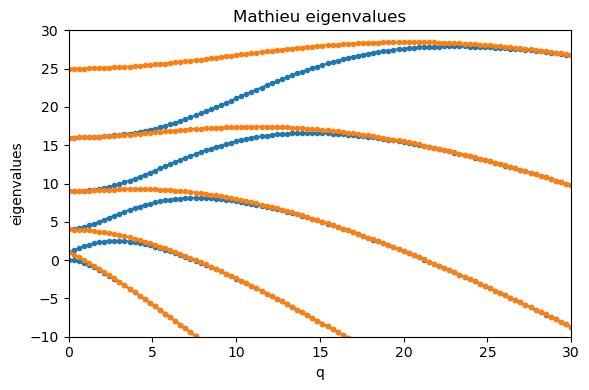

In [4]:
"""
Dedalus script solving for the eigenvalues of the Mathieu equation. This script
demonstrates solving a periodic eigenvalue problem with nonconstant coefficients
and produces a plot of the Mathieu eigenvalues 'a' as a function of the
parameter 'q'. It should take just a few seconds to run (serial only).

We use a Fourier basis to solve the EVP:
    dx(dx(y)) + (a - 2*q*cos(2*x))*y = 0
where 'a' is the eigenvalue. Periodicity is enforced by using the Fourier basis.

To run and plot:
    $ python3 mathieu_evp.py
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
N = 32
q_list = np.linspace(0, 30, 100)

# Basis
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=np.complex128)
basis = d3.ComplexFourier(coord, N, bounds=(0, 2*np.pi))

# Fields
y = dist.Field(bases=basis)
a = dist.Field()

# Substitutions
x = dist.local_grid(basis)
q = dist.Field()
cos_2x = dist.Field(bases=basis)
cos_2x['g'] = np.cos(2 * x)
dx = lambda A: d3.Differentiate(A, coord)

# Problem
problem = d3.EVP([y], eigenvalue=a, namespace=locals())
problem.add_equation("dx(dx(y)) + (a - 2*q*cos_2x)*y  = 0")

# Solver
solver = problem.build_solver()
evals = []
for qi in q_list:
    q['g'] = qi
    solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
    sorted_evals = np.sort(solver.eigenvalues.real)
    evals.append(sorted_evals[:10])
evals = np.array(evals)

# Plot
fig = plt.figure(figsize=(6, 4))
plt.plot(q_list, evals[:, 0::2], '.-', c='C0')
plt.plot(q_list, evals[:, 1::2], '.-', c='C1')
plt.xlim(q_list.min(), q_list.max())
plt.ylim(-10, 30)
plt.xlabel("q")
plt.ylabel("eigenvalues")
plt.title("Mathieu eigenvalues")
plt.tight_layout()
plt.savefig("mathieu_eigenvalues.png", dpi=200)